In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import math

In [2]:
mitbih = pd.read_csv("mitbih_test.csv")
mitbih_train = pd.read_csv("mitbih_train.csv")

In [3]:
data = mitbih_train.iloc[:, :186].values
labels = mitbih_train.iloc[:, 187].values

In [4]:
from keras.utils import to_categorical

one_hot_labels = np.zeros((len(labels), 5))
one_hot_labels[:] = to_categorical(labels[:], num_classes = 5)

Using TensorFlow backend.


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size = 0.33, random_state = 42)

In [6]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Convolution1D, MaxPooling1D, SeparableConv1D, Flatten, MaxPool1D
from keras.optimizers import Adam
from keras.models import Model

#X_train[:] = add_gaussian_noise(X_train[:])#Small data augmentation
#X_test[:] = add_gaussian_noise(X_test[:])#Small data augmentation

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

im_shape=(X_train.shape[1],1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


model = Model(inputs= inputs_cnn, outputs=main_output)

In [7]:
model.compile(optimizer = Adam(lr = 100e-5),
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

In [8]:
EPOCHS = 10
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = EPOCHS, shuffle = True, class_weight = 'auto')

Train on 46928 samples, validate on 11732 samples
Epoch 1/10
46928/46928 [==============================] - 56s 1ms/step - loss: 0.1565 - accuracy: 0.9564 - val_loss: 0.1111 - val_accuracy: 0.9691
Epoch 2/10
46928/46928 [==============================] - 47s 1ms/step - loss: 0.0890 - accuracy: 0.9744 - val_loss: 0.1223 - val_accuracy: 0.9601
Epoch 3/10
46928/46928 [==============================] - 49s 1ms/step - loss: 0.0688 - accuracy: 0.9799 - val_loss: 0.0818 - val_accuracy: 0.9777
Epoch 4/10
46928/46928 [==============================] - 43s 923us/step - loss: 0.0556 - accuracy: 0.9835 - val_loss: 0.0747 - val_accuracy: 0.9804
Epoch 5/10
46928/46928 [==============================] - 45s 959us/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.0668 - val_accuracy: 0.9795
Epoch 6/10
46928/46928 [==============================] - 49s 1ms/step - loss: 0.0398 - accuracy: 0.9875 - val_loss: 0.0665 - val_accuracy: 0.9833
Epoch 7/10
46928/46928 [==============================] - 48s 1m

In [9]:
print(model.evaluate(X_test, y_test))

28893/28893 [==============================] - 8s 264us/step
[0.07291394580168085, 0.9833523631095886]


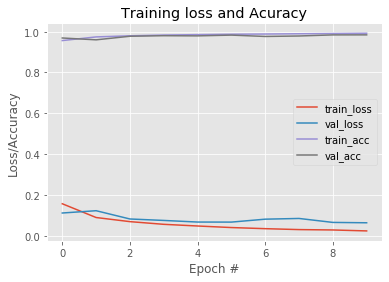

In [10]:
N = np.arange(0, EPOCHS)
title = "Training loss and Acuracy"

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label = "train_loss")
plt.plot(N, history.history["val_loss"], label = "val_loss")
plt.plot(N, history.history["accuracy"], label = "train_acc")
plt.plot(N, history.history["val_accuracy"], label = "val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [52]:
predictions = model.predict(X_test)
predictions = np.where(predictions < 0.5, 0, 1)

In [53]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("Accuracy: {0:.2f}".format(100.0 * accuracy_score(y_test, predictions)))
print("Precision: {0:.2f}".format(100.0 * precision_score(y_test, predictions, average='micro')))
print("F1 score: {0:.2f}".format(100.0 * f1_score(y_test, predictions, average='micro')))

print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))

Accuracy: 98.32
Precision: 98.39
F1 score: 98.36
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23969
           1       0.94      0.76      0.84       713
           2       0.92      0.97      0.95      1894
           3       0.88      0.67      0.76       228
           4       0.99      0.99      0.99      2089

   micro avg       0.98      0.98      0.98     28893
   macro avg       0.95      0.88      0.91     28893
weighted avg       0.98      0.98      0.98     28893
 samples avg       0.98      0.98      0.98     28893



In [11]:
model_final = Model(inputs=model.input, outputs=model.layers[-2].output)
model_final.compile(optimizer = Adam(lr = 100e-5),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])




In [12]:
representations = []

dataSVM = np.array(data.copy())

dataSVM = dataSVM.reshape(len(dataSVM), dataSVM.shape[1],1)

print(dataSVM.shape)
for i in range(len(mitbih_train)):
    representations.append(model_final.predict(np.array([dataSVM[i]])))
    

(87553, 186, 1)


In [13]:
representations = np.array(representations).squeeze()

In [14]:
print(representations)

[[ 8.471641   0.         7.0719285 ...  0.         0.        13.370941 ]
 [ 0.         0.        10.054615  ...  0.         5.069747  14.553977 ]
 [ 0.         0.        23.35943   ...  0.         4.951066   7.659453 ]
 ...
 [16.970627   0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [12.823581   0.         0.        ...  0.         0.         0.       ]]


In [21]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(representations, one_hot_labels, test_size = 0.33, random_state = 42)

In [38]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_SVM)

X_train_SVM = scaling.transform(X_train_SVM)
X_test_SVM = scaling.transform(X_test_SVM)

In [39]:
print(X_train_SVM)

[[-0.9781257  -1.         -0.6172528  ... -1.         -0.8313125
  -0.89044434]
 [-1.         -1.         -0.566249   ... -1.         -1.
  -0.5601212 ]
 [-1.         -1.          0.24314582 ... -1.         -0.9763084
  -1.        ]
 ...
 [-0.48547786 -0.41812706 -1.         ... -1.         -1.
  -1.        ]
 [-0.9218145  -1.         -0.14662355 ... -1.         -1.
  -0.5023154 ]
 [-0.64516777 -1.         -0.8829618  ... -1.         -1.
  -0.69296116]]


In [48]:
clf = OneVsRestClassifier(LinearSVC(dual=False))#SVC(kernel='poly'))#SVC(kernel='rbf'))#

clf.fit(X_train_SVM, y_train_SVM)

y_pred = clf.decision_function(X_test_SVM)

rectified_prediction = np.where(y_pred < 0.5, 0, 1)

In [49]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print("Accuracy: {0:.2f}".format(100 * accuracy_score(y_test_SVM, rectified_prediction)))
print("Precision: {0:.2f}".format(100 * precision_score(y_test_SVM, rectified_prediction, average='micro')))
print("F1 score: {0:.2f}".format(100 * f1_score(y_test_SVM, rectified_prediction, average='micro')))

print('Classification Report:')
print(sklearn.metrics.classification_report(y_test_SVM, rectified_prediction))

Accuracy: 96.90
Precision: 99.23
F1 score: 98.05
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     23969
           1       0.97      0.72      0.82       713
           2       0.98      0.91      0.94      1894
           3       0.98      0.51      0.67       228
           4       1.00      0.98      0.99      2089

   micro avg       0.99      0.97      0.98     28893
   macro avg       0.99      0.82      0.88     28893
weighted avg       0.99      0.97      0.98     28893
 samples avg       0.97      0.97      0.97     28893



C:\Users\damja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


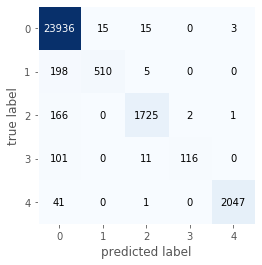

In [51]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

validation_numerical = np.argmax(y_test_SVM, axis = 1)
predictions_numerical = np.argmax(rectified_prediction, axis = 1)

cm = confusion_matrix(y_target=validation_numerical, 
                      y_predicted=predictions_numerical, 
                      binary=False)
cm
fig, ax = plot_confusion_matrix(cm)
plt.show()